<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Recurrent Neural Networks (RNNs)

_Author: Riley Dallas (ATX), Patrick Wales-Dinan (SF), Noah Christiansen_

---


### Learning Objectives

- Learn how to train/test split for sequence data
- Use `TimeseriesGenerator` to prep our time series data for modeling
- Create a basic RNN model using `keras`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

KeyboardInterrupt: 

## Load data: AAPL stock prices

We will use the [AlphaVantage API](https://www.alphavantage.co/documentation/) to gather Apple stock data for the last 20 years or so. Though you are also welcome to query another stock ticker if you would like.

Below is a helper function for querying the API. You can obtain a free API key from AlphaVantage, but we can also use any string in place of one.

In [3]:
def get_stock_data(symbol,
                   function = "TIME_SERIES_DAILY",
                   interval = "5min", ## only used with TIME_SERIES_INTRADAY function
                   apikey = "key",
                   outputsize = "compact"):
    base_url = "https://www.alphavantage.co/query"

    res = requests.get(url = base_url, params = {
            "function":function,
            "symbol":symbol,
            "interval":interval,
            "apikey":apikey,
            "outputsize":outputsize
    })
    
    data = res.json()
    data_key = list(data.keys())[1]
    data_df = pd.DataFrame(data[data_key]).T
    
    data_df.index = pd.to_datetime(data_df.index)
    data_df.sort_index(inplace = True)
    data_df.rename(columns = {
        "1. open":"Open",
        "2. high":"High",
        "3. low":"Low",
        "4. close":"Close",
        "5. volume":"Volume"}, inplace = True)
    
    return data_df.astype(float)

In [6]:
# Load stock data using the function above
prices = get_stock_data("AAPL", outputsize= 'full')

In [7]:
prices.shape

(5624, 5)

## `DateTime` Index
---

Since these are time series datasets, we need the indices to be datetime objects. Let's check our index and convert it to datetime if it isn't already.

In [9]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5624 entries, 1999-11-01 to 2022-03-08
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5624 non-null   float64
 1   High    5624 non-null   float64
 2   Low     5624 non-null   float64
 3   Close   5624 non-null   float64
 4   Volume  5624 non-null   float64
dtypes: float64(5)
memory usage: 263.6 KB


## Data cleaning: Prices
---

For Apple's stock prices, we'll need to do a few things:
1. De-trend the dataset using `.pct_change()`
2. Drop any `NaN`s that were created from step 1

<AxesSubplot:>

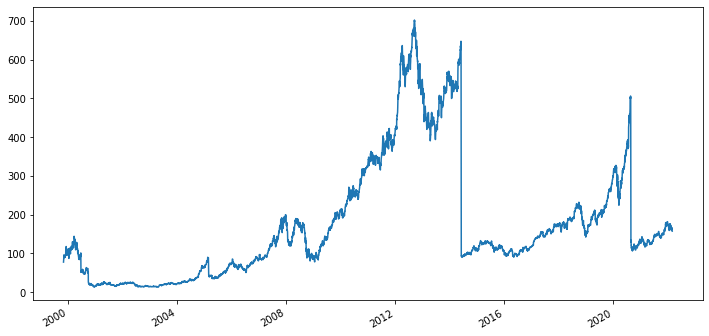

In [10]:
# Plot Close column
prices['Close'].plot(figsize = (12,6))

In [11]:
# Convert prices to be percent changes from prior row
prices = prices.pct_change()
prices.head()

,Open,High,Low,Close,Volume
1999-11-01,NaN,NaN,NaN,NaN,NaN
1999-11-02,-0.025000,0.012393,-0.000775,0.033883,0.433120
1999-11-03,0.046410,0.019097,0.047730,0.015576,-0.177271
1999-11-04,0.005391,0.025465,-0.004691,0.026012,0.154124
1999-11-05,0.031197,0.035141,0.041925,0.056087,0.099507


In [12]:
# Drop nulls
prices.dropna(inplace = True)

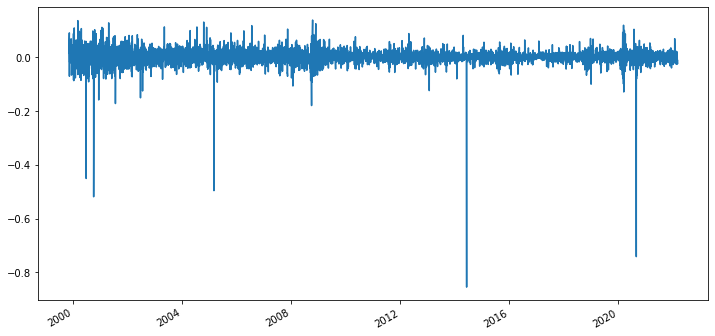

In [13]:
# Plot Close column again
prices['Close'].plot(figsize = (12,6));

## Create `Target` column
---

Our column of interest is the `Close` prices. We could build a regression model, where we predict the actual percentage change, or we could set this up as a binary classification problem:
- 1: The `Close` price was greater than or equal to the previous day
- 0: The `Close` price was lower than the previous day

We'll go with the latter option. In the cell below, let's create our binary `Target` column.

In [16]:
# Create Target column
prices['target'] = (prices['Close'] >= 0).astype(int)

In [17]:
prices['target'].value_counts(normalize= True)

1    0.525165
0    0.474835
Name: target, dtype: float64

In [18]:
prices.head()

,Open,High,Low,Close,Volume,target
1999-11-02,-0.025000,0.012393,-0.000775,0.033883,0.433120,1
1999-11-03,0.046410,0.019097,0.047730,0.015576,-0.177271,1
1999-11-04,0.005391,0.025465,-0.004691,0.026012,0.154124,1
1999-11-05,0.031197,0.035141,0.041925,0.056087,0.099507,1
1999-11-08,0.036989,0.105918,0.032738,0.091269,1.281446,1


In [ ]:
# Check value_counts

## Train/Test Split
---

Since we're dealing with time series data, we don't want the model to be able to see the future. 

<details><summary>What do we need to do in train_test_split?</summary>

- set `shuffle=False` so that the order is maintained
</details>

In [19]:
# Create X and y
X = prices.drop(columns=['target'])
y = prices['target']

In [21]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.05, shuffle= False)
X_train.shape, X_test.shape

((5341, 5), (282, 5))

In [22]:
# Check target mean for both train and test
y_train.mean(), y_test.mean()

(0.526305935218124, 0.5035460992907801)

## Scaling
---

You want to scale your data for any model that uses gradient descent, which includes neural networks.

In [23]:
# Scale training and testing data
sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

## `TimeseriesGenerator`
---

We'll now convert our data into series' using [`TimeseriesGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator). The `length` parameter dictates how many rows will constitute a sample. The generator also creates our batches.

```python
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=3, batch_size=64)
```

In the cells below, convert your training and validation data into sequences.

In [24]:
# Create training sequences
train_seq = TimeseriesGenerator(X_train_sc, y_train, length= 3, batch_size= 64)

In [68]:
# First batch of sequences

train_seq[0][0].shape

(64, 3, 5)

In [28]:
# first batch of target values
train_seq[0][1].shape

(64,)

In [29]:
# Create test sequences
test_seq = TimeseriesGenerator(X_test_sc, y_test, length= 3, batch_size= 64)

## Modeling time!
---

Now it's time to design our RNN model. We'll have:

- 2 [`GRU`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) layers
- 1 `Dense` output layer

We're doing a binary classification problem.

In [30]:
## Check shape of a single sequence of data (this will be the input shape for our model)
train_seq[0][0][0].shape

(3, 5)

In [31]:
len(train_seq)

84

In [32]:
# how many batches in the whole testing df
len(test_seq)

5

In [33]:
## First batch of testing sequences (64 sequences per batch, 3 observations per sequence, 5 columns per observation)
test_seq[0][0].shape

(64, 3, 5)

<details><summary>What should our output layer look like?</summary>

- 1 neuron
- sigmoid activation function
- this way, our model predicts a probability
</details>

In [35]:
# Design RNN
model = Sequential()

model.add(GRU(16, input_shape = train_seq[0][0][0].shape,
             return_sequences = True))  ## First GRU layer returns hidden state, passes back into self
model.add(GRU(8, return_sequences = False))## Second GRU layer passes outputs forward to next layer

model.add(Dense(8, activation = 'relu'))

model.add(Dense(1, activation = 'sigmoid'))
# Fit to training sequences, validate with test sequences
model.compile(optimizer= Adam(0.01), loss = 'bce', metrics= ['accuracy'])

2022-03-08 20:32:52.860851: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3, 16)             1104      
                                                                 
 gru_1 (GRU)                 (None, 8)                 624       
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,809
Trainable params: 1,809
Non-trainable params: 0
_________________________________________________________________


In [37]:
## Plot Training & Validation Loss
history = model.fit(train_seq, epochs= 50, verbose= 1, validation_data= test_seq)

Epoch 1/50
84/84 [==============================] - 5s 14ms/step - loss: 0.6923 - accuracy: 0.5260 - val_loss: 0.6931 - val_accuracy: 0.5018
Epoch 2/50
84/84 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.5367 - val_loss: 0.6919 - val_accuracy: 0.5161
Epoch 3/50
84/84 [==============================] - 0s 4ms/step - loss: 0.6882 - accuracy: 0.5386 - val_loss: 0.6929 - val_accuracy: 0.5161
Epoch 4/50
84/84 [==============================] - 0s 4ms/step - loss: 0.6877 - accuracy: 0.5369 - val_loss: 0.6922 - val_accuracy: 0.4946
Epoch 5/50
84/84 [==============================] - 0s 4ms/step - loss: 0.6863 - accuracy: 0.5451 - val_loss: 0.6927 - val_accuracy: 0.5054
Epoch 6/50
84/84 [==============================] - 0s 4ms/step - loss: 0.6851 - accuracy: 0.5465 - val_loss: 0.6971 - val_accuracy: 0.5125
Epoch 7/50
84/84 [==============================] - 0s 4ms/step - loss: 0.6837 - accuracy: 0.5502 - val_loss: 0.7023 - val_accuracy: 0.4910
Epoch 8/50
84/84 [=

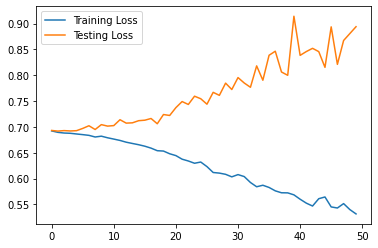

In [38]:
## Plot Training & Validation Accuracy
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "Testing Loss")
plt.legend();

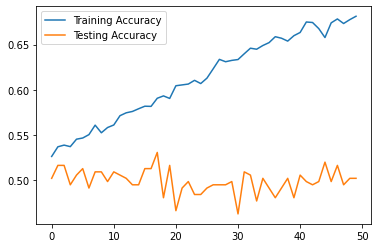

In [39]:
plt.plot(history.history['accuracy'], label = "Training Accuracy")
plt.plot(history.history['val_accuracy'], label = "Testing Accuracy")
plt.legend();

In [43]:
# Design RNN
model_2 = Sequential()

model_2.add(LSTM(16, input_shape = train_seq[0][0][0].shape,
             return_sequences = True))  ## First GRU layer returns hidden state, passes back into self
model_2.add(LSTM(8, return_sequences = False))## Second GRU layer passes outputs forward to next layer

model_2.add(Dense(8, activation = 'relu'))

model_2.add(Dense(1, activation = 'sigmoid'))
# Fit to training sequences, validate with test sequences
model_2.compile(optimizer= Adam(0.01), loss = 'bce', metrics= ['accuracy'])

In [44]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 16)             1408      
                                                                 
 lstm_1 (LSTM)               (None, 8)                 800       
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,289
Trainable params: 2,289
Non-trainable params: 0
_________________________________________________________________


In [46]:
history_2 = model_2.fit(train_seq, epochs = 50, verbose = 1, validation_data = test_seq)

Epoch 1/50
84/84 [==============================] - 4s 14ms/step - loss: 0.6916 - accuracy: 0.5260 - val_loss: 0.6972 - val_accuracy: 0.4839
Epoch 2/50
84/84 [==============================] - 0s 5ms/step - loss: 0.6901 - accuracy: 0.5303 - val_loss: 0.6954 - val_accuracy: 0.5125
Epoch 3/50
84/84 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.5341 - val_loss: 0.6928 - val_accuracy: 0.5054
Epoch 4/50
84/84 [==============================] - 0s 4ms/step - loss: 0.6875 - accuracy: 0.5363 - val_loss: 0.6904 - val_accuracy: 0.5305
Epoch 5/50
84/84 [==============================] - 0s 4ms/step - loss: 0.6866 - accuracy: 0.5444 - val_loss: 0.6913 - val_accuracy: 0.5376
Epoch 6/50
84/84 [==============================] - 0s 4ms/step - loss: 0.6845 - accuracy: 0.5427 - val_loss: 0.6931 - val_accuracy: 0.5018
Epoch 7/50
84/84 [==============================] - 0s 4ms/step - loss: 0.6841 - accuracy: 0.5513 - val_loss: 0.6940 - val_accuracy: 0.5054
Epoch 8/50
84/84 [=

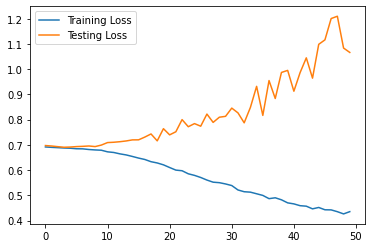

In [47]:
## Plot Training & Validation Accuracy
plt.plot(history_2.history['loss'], label = "Training Loss")
plt.plot(history_2.history['val_loss'], label = "Testing Loss")
plt.legend();

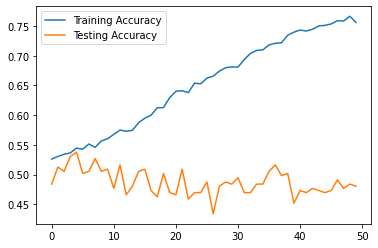

In [48]:
plt.plot(history_2.history['accuracy'], label = "Training Accuracy")
plt.plot(history_2.history['val_accuracy'], label = "Testing Accuracy")
plt.legend();

In [49]:
from tensorflow.keras.regularizers import l2

In [52]:

# Design RNN - Using LSTM layers & Regularization
model_3 = Sequential()

model_3.add(LSTM(16, input_shape = train_seq[0][0][0].shape,
              return_sequences=True)) ## First LSTM layer returns hidden state, passes back into self
model_3.add(LSTM(8, return_sequences=False)) ## Second LSTM layer passes outputs forward to next layer

model_3.add(Dense(8, activation = 'relu', kernel_regularizer=l2(0.001)))
model_3.add(Dropout(0.2))
model_3.add(Dense(1, activation = 'sigmoid'))

model_3.compile(optimizer = Adam(0.01), loss = 'bce', metrics = ['accuracy'])
model_3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 3, 16)             1408      
                                                                 
 lstm_5 (LSTM)               (None, 8)                 800       
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,289
Trainable params: 2,289
Non-trainable params: 0
_________________________________________________________________


In [53]:
history_3 = model_3.fit(train_seq, epochs= 50, verbose=1, validation_data= test_seq)

Epoch 1/50
84/84 [==============================] - 5s 15ms/step - loss: 0.6939 - accuracy: 0.5249 - val_loss: 0.6934 - val_accuracy: 0.5054
Epoch 2/50
84/84 [==============================] - 0s 4ms/step - loss: 0.6918 - accuracy: 0.5260 - val_loss: 0.6932 - val_accuracy: 0.5054
Epoch 3/50
84/84 [==============================] - 0s 4ms/step - loss: 0.6922 - accuracy: 0.5260 - val_loss: 0.6934 - val_accuracy: 0.5054
Epoch 4/50
84/84 [==============================] - 0s 4ms/step - loss: 0.6918 - accuracy: 0.5260 - val_loss: 0.6936 - val_accuracy: 0.5054
Epoch 5/50
84/84 [==============================] - 0s 5ms/step - loss: 0.6907 - accuracy: 0.5260 - val_loss: 0.6921 - val_accuracy: 0.5054
Epoch 6/50
84/84 [==============================] - 0s 4ms/step - loss: 0.6908 - accuracy: 0.5260 - val_loss: 0.6914 - val_accuracy: 0.5054
Epoch 7/50
84/84 [==============================] - 0s 5ms/step - loss: 0.6900 - accuracy: 0.5223 - val_loss: 0.6910 - val_accuracy: 0.5054
Epoch 8/50
84/84 [=

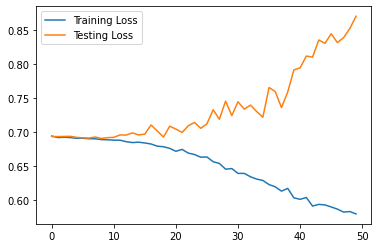

In [54]:
## Plot Training & Validation Accuracy
plt.plot(history_3.history['loss'], label = "Training Loss")
plt.plot(history_3.history['val_loss'], label = "Testing Loss")
plt.legend();

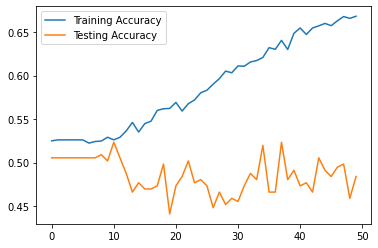

In [55]:
plt.plot(history_3.history['accuracy'], label = "Training Accuracy")
plt.plot(history_3.history['val_accuracy'], label = "Testing Accuracy")
plt.legend();

In [56]:
from tensorflow.keras.callbacks import EarlyStopping

## Your turn!
---

Can you improve this model? Try to build a model that minimizes the testing loss even more!

In [59]:
# Create training sequences
train_seq1 = TimeseriesGenerator(X_train_sc, y_train, length= 10, batch_size= 64)

In [60]:
# Create test sequences
test_seq1 = TimeseriesGenerator(X_test_sc, y_test, length= 10, batch_size= 64)

In [83]:
# Design RNN - Using LSTM layers & Regularization
model_4 = Sequential()

model_4.add(LSTM(16, input_shape = train_seq1[0][0][0].shape,
              return_sequences=True)) ## First LSTM layer returns hidden state, passes back into self
model_4.add(LSTM(8, return_sequences=False)) ## Second LSTM layer passes outputs forward to next layer

model_4.add(Dense(8, activation = 'relu', kernel_regularizer=l2(0.001)))
model_4.add(Dropout(0.2))
# model_4.add(Dense(8, activation = 'relu')
#model_4.add(Dropout(0.2))
model_4.add(Dense(1, activation = 'sigmoid'))

model_4.compile(optimizer = Adam(0.008), loss = 'bce', metrics = ['accuracy'])
model_4.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 10, 16)            1408      
                                                                 
 lstm_15 (LSTM)              (None, 8)                 800       
                                                                 
 dense_14 (Dense)            (None, 8)                 72        
                                                                 
 dropout_5 (Dropout)         (None, 8)                 0         
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,289
Trainable params: 2,289
Non-trainable params: 0
_________________________________________________________________


In [84]:
## Plot Training & Validation Loss
history_4 = model_4.fit(train_seq1, epochs= 50, verbose= 1, validation_data= test_seq1)

Epoch 1/50
84/84 [==============================] - 5s 19ms/step - loss: 0.6974 - accuracy: 0.5192 - val_loss: 0.6948 - val_accuracy: 0.5037
Epoch 2/50
84/84 [==============================] - 1s 7ms/step - loss: 0.6927 - accuracy: 0.5260 - val_loss: 0.6937 - val_accuracy: 0.5037
Epoch 3/50
84/84 [==============================] - 1s 8ms/step - loss: 0.6919 - accuracy: 0.5260 - val_loss: 0.6939 - val_accuracy: 0.5037
Epoch 4/50
84/84 [==============================] - 1s 8ms/step - loss: 0.6919 - accuracy: 0.5260 - val_loss: 0.6937 - val_accuracy: 0.5037
Epoch 5/50
84/84 [==============================] - 1s 8ms/step - loss: 0.6919 - accuracy: 0.5260 - val_loss: 0.6958 - val_accuracy: 0.5037
Epoch 6/50
84/84 [==============================] - 1s 8ms/step - loss: 0.6917 - accuracy: 0.5260 - val_loss: 0.6941 - val_accuracy: 0.5037
Epoch 7/50
84/84 [==============================] - 1s 8ms/step - loss: 0.6912 - accuracy: 0.5260 - val_loss: 0.6916 - val_accuracy: 0.5037
Epoch 8/50
84/84 [=

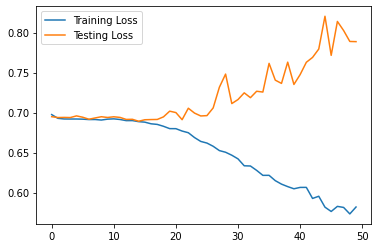

In [87]:
## Plot Training & Validation Accuracy
plt.plot(history_4.history['loss'], label = "Training Loss")
plt.plot(history_4.history['val_loss'], label = "Testing Loss")
plt.legend();

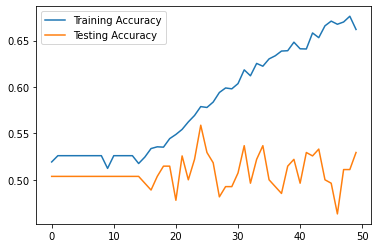

In [89]:
plt.plot(history_4.history['accuracy'], label = "Training Accuracy")
plt.plot(history_4.history['val_accuracy'], label = "Testing Accuracy")
plt.legend();

In [90]:
model_4.evaluate(test_seq1)

5/5 [==============================] - 0s 2ms/step - loss: 0.7886 - accuracy: 0.5294


[0.7885934710502625, 0.529411792755127]